# Hyperparameter tuning and lags selection

Skforecast library combines several model tuning strategies with [backtesting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html) to identify the combination of lags and hyperparameters that achieve the best prediction performance.

## Libraries

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import  random_search_forecaster
from skforecast.model_selection import  bayesian_search_forecaster
from sklearn.metrics import mean_squared_error

## Data

Train dates      : 1991-07-01 00:00:00 --- 2001-01-01 00:00:00  (n=115)
Validation dates : 2001-02-01 00:00:00 --- 2006-01-01 00:00:00  (n=60)
Test dates       : 2006-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=29)


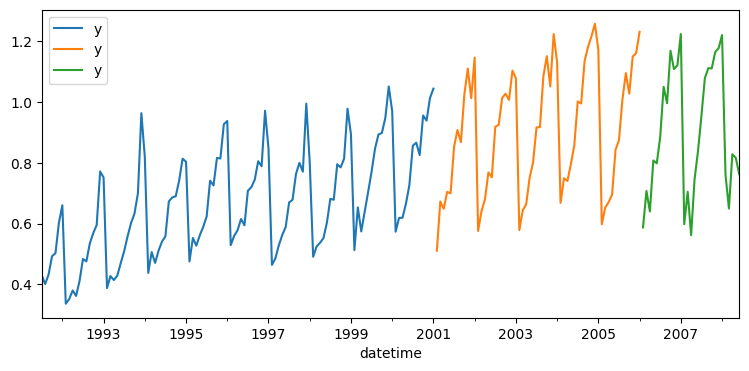

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()

# Train-val-test dates
# ==============================================================================
end_train = '2001-01-01 23:59:00'
end_val = '2006-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  (n={len(data.loc[end_train:end_val])})")
print(f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_val:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:end_val].plot(ax=ax, label='validation')
data.loc[end_val:].plot(ax=ax, label='test')
ax.legend();

## Grid search

Grid search requires two grids, one with the different lag configurations (`lags_grid`) and the other with the list of hyperparameters to be tested (`param_grid`). The process comprises the following steps:

1. `grid_search_forecaster` creates a copy of the forecaster object and replaces the `lags` argument with the first option appearing in `lags_grid`.

2. The function validates all combinations of hyperparameters presented in `param_grid` by [backtesting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html).

3. The function repeats these two steps until it runs through all the possibilities (lags + hyperparameters).

4. If `return_best = True`, the original forecaster is trained with the best lags and hyperparameters configuration found.

In [3]:
# Grid search hyperparameter and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_val, 'y'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 12,
                   refit              = True,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:07<00:00,  2.57s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.03344857370906804



In [4]:
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.033449,5,50
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.039221,10,50
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 100}",0.039266,15,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.039526,5,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.040241,10,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 50}",0.040765,15,50
17,"[1, 2, 3, 20]","{'max_depth': 15, 'n_estimators': 100}",0.043909,15,100
13,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.044992,5,100
12,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.046224,5,50
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.048666,5,50


In [5]:
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=5, n_estimators=50, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2006-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-03-08 15:18:11 
Last fit date: 2023-03-08 15:18:19 
Skforecast version: 0.7.0 
Python version: 3

## Random search

Randomized search on hyperparameters. In contrast to `grid_search_forecaster`, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified possibilities. The number of parameter settings that are tried is given by `n_iter`.

It is important to note that random sampling is only applied to the model hyperparameters, but not to the lags. All lags specified by the user are evaluated.

In [6]:
# Random search hyperparameter and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 5]

# Regressor hyperparameters
param_distributions = {'n_estimators': np.arange(start=10, stop=100, step=1, dtype=int),
                       'max_depth': np.arange(start=5, stop=30, step=1, dtype=int)}

results = random_search_forecaster(
              forecaster           = forecaster,
              y                    = data.loc[:end_val, 'y'],
              steps                = 12,
              lags_grid            = lags_grid,
              param_distributions  = param_distributions,
              n_iter               = 5,
              metric               = 'mean_squared_error',
              refit                = True,
              initial_train_size   = len(data.loc[:end_train]),
              fixed_train_size     = False,
              return_best          = True,
              random_state         = 123,
              verbose              = False
          )

results

Number of models compared: 10.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:04<00:00,  2.18s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'n_estimators': 77, 'max_depth': 17}
  Backtesting metric: 0.03147248676391345



,lags,params,mean_squared_error,n_estimators,max_depth
9,"[1, 2, 3, 4, 5]","{'n_estimators': 77, 'max_depth': 17}",0.031472,77,17
7,"[1, 2, 3, 4, 5]","{'n_estimators': 66, 'max_depth': 24}",0.033616,66,24
5,"[1, 2, 3, 4, 5]","{'n_estimators': 96, 'max_depth': 19}",0.033761,96,19
6,"[1, 2, 3, 4, 5]","{'n_estimators': 52, 'max_depth': 17}",0.040640,52,17
8,"[1, 2, 3, 4, 5]","{'n_estimators': 94, 'max_depth': 28}",0.044071,94,28
3,"[1, 2, 3]","{'n_estimators': 94, 'max_depth': 28}",0.048469,94,28
0,"[1, 2, 3]","{'n_estimators': 96, 'max_depth': 19}",0.049969,96,19
2,"[1, 2, 3]","{'n_estimators': 66, 'max_depth': 24}",0.060074,66,24
4,"[1, 2, 3]","{'n_estimators': 77, 'max_depth': 17}",0.060801,77,17
1,"[1, 2, 3]","{'n_estimators': 52, 'max_depth': 17}",0.067000,52,17


## Bayesian search

Grid and random search generate good results, especially when the search range is narrowed down. But they share a common flaw, neither of them takes into account the results obtained so far, which prevents them from focusing the search on the regions of greatest interest while avoiding unnecessary ones.

An alternative is to search for hyperparameters using Bayesian optimization methods. In general terms, Bayesian hyperparameter optimization consists of creating a probabilistic model in which the objective function is the model validation metric (RMSE, AUC, accuracy...). With this strategy, the search is redirected at each iteration to the regions of greatest interest. The ultimate goal is to reduce the number of hyperparameter combinations with which the model is evaluated, choosing only the best candidates. This means that the advantage over the other mentioned strategies is maximized when the search space is very large or the model evaluation is very slow.

It is important to note that Bayesian search is only applied to the hyperparameters of the model, but not to the lags. All lags specified by the user are evaluated.

Skforecast includes two bayesian optimization engines: [Scikit-Optimize](https://scikit-optimize.github.io/stable/) and [Optuna](https://optuna.org/).

### Optuna

Bayesian optimization using Optuna performs optimization with its [Study object](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study). This experiment minimizes  the metric generated by [backtesting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html). 

Additional parameters can be included when `bayesian_search_forecaster` calls [create_study](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.create_study.html) and [optimize method](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study.optimize) using the `kwargs_create_study` and `kwargs_study_optimize` arguments respectively as `{'parameter_name': parameter_value}`.

To use this engine, `search_space` argument must be a `function` as shown below. Optuna uses the [Trial object](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial) to generate each search space.

In [7]:
# Bayesian search hyperparameter and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 5]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {'n_estimators'     : trial.suggest_int('n_estimators', 10, 20),
                     'min_samples_leaf' : trial.suggest_float('min_samples_leaf', 1., 3.7, log=True),
                     'max_features'     : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
                    } 
    return search_space

results, frozen_trial = bayesian_search_forecaster(
                            forecaster            = forecaster,
                            y                     = data.loc[:end_val, 'y'],
                            lags_grid             = lags_grid,
                            search_space          = search_space,
                            steps                 = 12,
                            metric                = 'mean_absolute_error',
                            refit                 = True,
                            initial_train_size    = len(data.loc[:end_train]),
                            fixed_train_size      = True,
                            n_trials              = 10,
                            random_state          = 123,
                            return_best           = False,
                            verbose               = False,
                            engine                = 'optuna',
                            kwargs_create_study   = {},
                            kwargs_study_optimize = {}
                        )

results

Number of models compared: 20,
         10 bayesian search in each lag configuration.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:01<00:00,  1.08it/s]


,lags,params,mean_absolute_error,n_estimators,min_samples_leaf,max_features
4,"[1, 2, 3]","{'n_estimators': 12, 'min_samples_leaf': 1.258...",0.217299,12,1.258033,sqrt
7,"[1, 2, 3]","{'n_estimators': 13, 'min_samples_leaf': 2.283...",0.217401,13,2.283083,sqrt
9,"[1, 2, 3]","{'n_estimators': 14, 'min_samples_leaf': 3.218...",0.217481,14,3.218291,log2
8,"[1, 2, 3]","{'n_estimators': 14, 'min_samples_leaf': 1.907...",0.217481,14,1.907712,log2
3,"[1, 2, 3]","{'n_estimators': 14, 'min_samples_leaf': 1.081...",0.217481,14,1.081208,sqrt
6,"[1, 2, 3]","{'n_estimators': 17, 'min_samples_leaf': 1.525...",0.217677,17,1.525829,log2
0,"[1, 2, 3]","{'n_estimators': 17, 'min_samples_leaf': 1.454...",0.217677,17,1.454068,sqrt
1,"[1, 2, 3]","{'n_estimators': 17, 'min_samples_leaf': 1.739...",0.217677,17,1.739441,log2
2,"[1, 2, 3]","{'n_estimators': 15, 'min_samples_leaf': 1.670...",0.218018,15,1.670328,sqrt
5,"[1, 2, 3]","{'n_estimators': 16, 'min_samples_leaf': 3.038...",0.218105,16,3.038426,log2


`frozen_trial` contains the trial of the optimization of the [Study class](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study) for the best iteration.

In [8]:
frozen_trial

FrozenTrial(number=4, values=[0.21729924404290674], datetime_start=datetime.datetime(2023, 3, 8, 15, 18, 24, 84513), datetime_complete=datetime.datetime(2023, 3, 8, 15, 18, 24, 164882), params={'n_estimators': 12, 'min_samples_leaf': 1.2580328751834622, 'max_features': 'sqrt'}, distributions={'n_estimators': IntDistribution(high=20, log=False, low=10, step=1), 'min_samples_leaf': FloatDistribution(high=3.7, log=True, low=1.0, step=None), 'max_features': CategoricalDistribution(choices=('log2', 'sqrt'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=4, state=TrialState.COMPLETE, value=None)

### Scikit-optimize

Bayesian optimization with Skopt performs optimization with Gaussian processes. This is done with the function [gp_minimize](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html#skopt.gp_minimize) where the objective value to be minimized is calculated by [backtesting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html).

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100;">

<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b> &nbsp Warning</b>
</p>

This engine is deprecated since skforecast 0.7.0 in favor of optuna engine. To continue using it, install skforecast 0.6.0.
<br><br>
User guide: https://joaquinamatrodrigo.github.io/skforecast/0.6.0/user_guides/hyperparameter-tuning-and-lags-selection.html#scikit-optimize

</div>

## Hyperparameter tuning with custom metric

Besides the frequently used metrics: `mean_squared_error`, `mean_absolute_error`, and `mean_absolute_percentage_error`, it is possible to use any custom function as long as:

+ It includes the arguments:

    + `y_true`: true values of the series.

    + `y_pred`: predicted values.

+ It returns a numeric value (`float` or `int`).

It allows to evaluate of the predictive capability of the model in a wide range of scenarios, for example:

+ Consider only certain months, days, hours...

+ Consider only dates that are holidays.

+ Consider only the last step of the predicted horizon.

The following example using `grid_search_forecaster` shows how to forecast a 12-month horizon but considering only the last 3 months of each year to calculate the interest metric.

In [9]:
# Grid search hyperparameter and lags with custom metric
# ==============================================================================
def custom_metric(y_true, y_pred):
    """
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    """
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_squared_error(y_true[mask], y_pred[mask])
    
    return metric
    
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_val, 'y'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 12,
                   refit              = True,
                   metric             = custom_metric,
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

results_grid

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:08<00:00,  2.93s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.04867459231626605



,lags,params,custom_metric,max_depth,n_estimators
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.048675,5,50
17,"[1, 2, 3, 20]","{'max_depth': 15, 'n_estimators': 100}",0.052172,15,100
5,"[1, 2, 3]","{'max_depth': 15, 'n_estimators': 100}",0.055920,15,100
12,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.056981,5,50
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.057507,5,50
14,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.058631,10,50
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.060032,10,50
4,"[1, 2, 3]","{'max_depth': 15, 'n_estimators': 50}",0.063681,15,50
13,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.064490,5,100
15,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.066499,10,100


## Compare multiple metrics

All three functions (`grid_search_forecaster`, `random_search_forecaster`, and `bayesian_search_forecaster`) allow the calculation of multiple metrics for each forecaster configuration if a list is provided. This list may include custom metrics and the best model selection is done based on the first metric of the list.

In [10]:
# Grid search hyperparameter and lags with multiple metrics
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10 # Placeholder, the value will be overwritten
             )

# Metrics
metrics = ['mean_absolute_error', mean_squared_error, custom_metric]

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data.loc[:end_val, 'y'],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 12,
                    refit              = True,
                    metric             = metrics,
                    initial_train_size = len(data.loc[:end_train]),
                    fixed_train_size   = False,
                    return_best        = True,
                    verbose            = False
               )

results_grid

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:09<00:00,  3.15s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.14186925271863238



,lags,params,mean_absolute_error,mean_squared_error,custom_metric,max_depth,n_estimators
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.141869,0.033449,0.057507,5,50
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.144912,0.039221,0.066599,10,50
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 50}",0.152188,0.040765,0.085193,15,50
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.154576,0.040241,0.071078,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 100}",0.155862,0.039266,0.072183,15,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.160582,0.039526,0.069684,5,100
13,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.166288,0.044992,0.064490,5,100
17,"[1, 2, 3, 20]","{'max_depth': 15, 'n_estimators': 100}",0.167600,0.043909,0.052172,15,100
15,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.170615,0.048991,0.066499,10,100
12,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.172712,0.046224,0.056981,5,50


## Compare multiple regressors

It is also possible to tune several regressors in order to identify which one achieves better performance.


In [11]:
# Models to compare
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge

models = [RandomForestRegressor(random_state=123), 
          GradientBoostingRegressor(random_state=123),
          Ridge(random_state=123)]

# param_grid for each model
param_grids = {'RandomForestRegressor': {'n_estimators': [50, 100], 'max_depth': [5, 15]},
               'GradientBoostingRegressor': {'n_estimators': [20, 50], 'max_depth': [5, 10]},
               'Ridge': {'alpha': [0.01, 0.1, 1]}}

# Lags used as predictors
lags_grid = [3, 5]


df_results = pd.DataFrame()
for i, model in enumerate(models):
    print(f"Grid search for regressor: {model}")
    print(f"-------------------------")

    forecaster = ForecasterAutoreg(
                     regressor = model,
                     lags      = 3
                 )

    # Regressor hyperparameters
    param_grid = param_grids[list(param_grids)[i]]

    results_grid = grid_search_forecaster(
                       forecaster         = forecaster,
                       y                  = data.loc[:end_val, 'y'],
                       param_grid         = param_grid,
                       lags_grid          = lags_grid,
                       steps              = 3,
                       refit              = True,
                       metric             = 'mean_squared_error',
                       initial_train_size = len(data.loc[:end_train]),
                       fixed_train_size   = True,
                       return_best        = False,
                       verbose            = False
                   )
    
    # Create a column with model name
    results_grid['model'] = list(param_grids)[i]
    
    df_results = pd.concat([df_results, results_grid])

df_results.sort_values(by='mean_squared_error')

Grid search for regressor: RandomForestRegressor(random_state=123)
-------------------------
Number of models compared: 8.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:10<00:00,  5.38s/it]


Grid search for regressor: GradientBoostingRegressor(random_state=123)
-------------------------
Number of models compared: 8.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:01<00:00,  1.06it/s]


Grid search for regressor: Ridge(random_state=123)
-------------------------
Number of models compared: 6.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:00<00:00,  7.54it/s]


,lags,params,mean_squared_error,max_depth,n_estimators,model,alpha
4,"[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 50}",0.045461,5.0,50.0,RandomForestRegressor,NaN
6,"[1, 2, 3, 4, 5]","{'max_depth': 15, 'n_estimators': 50}",0.045826,15.0,50.0,RandomForestRegressor,NaN
5,"[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 100}",0.048252,5.0,100.0,RandomForestRegressor,NaN
7,"[1, 2, 3, 4, 5]","{'max_depth': 15, 'n_estimators': 100}",0.048994,15.0,100.0,RandomForestRegressor,NaN
0,"[1, 2, 3]",{'alpha': 0.01},0.054196,NaN,NaN,Ridge,0.01
3,"[1, 2, 3, 4, 5]",{'alpha': 0.01},0.054255,NaN,NaN,Ridge,0.01
4,"[1, 2, 3, 4, 5]",{'alpha': 0.1},0.054266,NaN,NaN,Ridge,0.10
1,"[1, 2, 3]",{'alpha': 0.1},0.054287,NaN,NaN,Ridge,0.10
7,"[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 50}",0.054291,10.0,50.0,GradientBoostingRegressor,NaN
6,"[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 20}",0.054773,10.0,20.0,GradientBoostingRegressor,NaN


## Hide progress bar

It is possible to hide the progress bar using the following code.

In [12]:
from tqdm import tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_val, 'y'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 12,
                   refit              = True,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 6.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 1}
  Backtesting metric: 0.08758355918903007



In [13]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>